In [29]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
from alvra_tools.timing_tool import *

import warnings
warnings.filterwarnings('ignore')

In [163]:
pgroup='p20572'
runnumber = 136

print ('run: {:04d}'.format(runnumber))

#############################################################
jsonfile = ''
jsonfile = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runnumber))[0]
titlestring = str(pgroup + ' --- ' +jsonfile.split('/')[-3])
run_name = jsonfile.split('/')[-3]
jsonfile

run: 0136


'/sf/alvra/data/p20572/raw/run0136-Fe3_CytC_XAS_5000fs_1.1uJ/meta/scan.json'

In [164]:
Two_diodes = False

reducedir='/das/work/p20/p20572/Camila/Reduced_XANES/'
saveflag=True

quantile_corr = 0.5

channel_delay_motor = channel_delay_topas
detector_XAS_1 = channel_diode_1
detector_XAS_2 = channel_diode_2
detector_Izero = channel_Izero110

#######################################################################################################
from sfdata import SFScanInfo
scan = SFScanInfo(jsonfile)
scan = remove_JF_from_scan(scan)

LoadXANES(Two_diodes, scan, detector_XAS_1, detector_XAS_2, detector_Izero, quantile_corr, saveflag, reducedir, run_name)
data, _ = load_reduced_data(pgroup, reducedir, [runnumber])
globals().update(data)

Processing: run0136-Fe3_CytC_XAS_5000fs_1.1uJ
Step 49 of 49: Processing acq0049

--------------------------------------------------------------------------------

SAR-CVME-TIFALL4:EvtSet   1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SARES11-GES1:CH1_VAL_GET  1001 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇
SAROP11-PBPS110:INTENSITY 1000 / 1001 -> 0% loss ▇▇▇▇▇▇▇▇▇▇

over the whole data set: 1000 / 1001 -> 0% loss
complete channels: 2 / 3 -> 33% incomplete

--------------------------------------------------------------------------------

FEL rep rate is 100.0 Hz
Laser rep rate is 50.0 Hz (delayed or dark)
Pump scheme is 1:1
Loaded 499 pump and 499 unpump shots
116 shots out of 499 survived
Step 49 of 49: Processed acq0049
correlation Diode (all shots) = 0.9979537463857678
------------------------------
Processed 49 out of 49 files


plotting only 1 diode


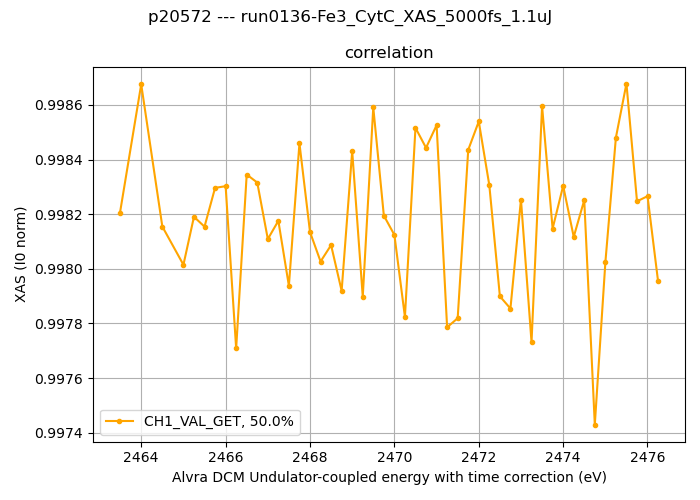

In [166]:
if not Two_diodes:
    detector_XAS_2 = detector_XAS_1
Plot_correlation(titlestring, scan, data, quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)

# Plot the run

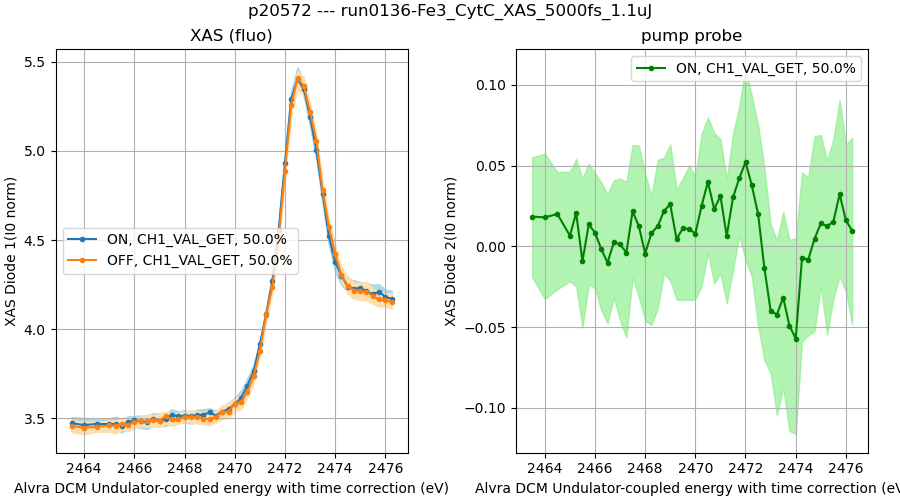

In [167]:
if Two_diodes:
    XAS1_pump_probe, XAS2_pump_probe, Energy_eV = Plot_2diodes_4figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)
    XAS1_pump_probe, XAS2_pump_probe, Energy_eV = Plot_2diodes_2figs(titlestring, scan, data, 
                                                              quantile_corr, detector_XAS_1, detector_XAS_2, timescan=False)
    
    Energy_eV, ave_pp1 = Plot_2diodes_Averaged_2figs(titlestring, scan, data, timescan=False)
else:
    XAS1_pump_probe, Energy_eV = Plot_1diode(titlestring, scan, data, 
                                            quantile_corr, detector_XAS_1, timescan=False)